# Load Libraries

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from scipy.stats import loguniform
import mlflow
import mlflow.sklearn
from sklearn.pipeline import Pipeline

import sys
sys.path.append("../src")
from myproject.pipelines.preprocessing_pipeline import preprocessing_pipeline
from myproject.pipelines.clean_pipeline import cleaning_pipeline

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("credit_classification_ml")

<Experiment: artifact_location='mlflow-artifacts:/454137213308002966', creation_time=1764624674955, experiment_id='454137213308002966', last_update_time=1764624674955, lifecycle_stage='active', name='credit_classification_ml', tags={'mlflow.experimentKind': 'custom_model_development'}>

# Data

In [ ]:
#Load dataset
df = pd.read_csv("/home/jakub/Pulpit/Credit Classification ML/data/raw/train.csv")

#Split data to X and y
X = df.drop(columns=['Credit_Score'])
y = df['Credit_Score']

#Split data to train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#Load cleaning ale preprocessing function
clean = cleaning_pipeline()
prep = preprocessing_pipeline()

/tmp/ipykernel_3363/1087931.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/home/jakub/Pulpit/Credit Classification ML/data/raw/train.csv")


# Baseline Model

In [ ]:
#Model Random FOrest
forest_clf = Pipeline([
    ("clean", clean),
    ("prep", prep),
    ("forest_clf", RandomForestClassifier(class_weight="balanced",
                                          random_state=42))
])

#K-Folds
cv = StratifiedKFold(n_splits=5, shuffle=True ,random_state=42)

#Metrics for scoring
scoring = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1_macro": "f1_macro",
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro",
}

#Cross validate
cv_result_base = cross_validate(
    forest_clf,
    X_train,
    y_train,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    return_train_score=False,
)

#model evaluation
cv_base_metrics_mean = {
    f"cv_{metrics}_mean_base": float(cv_result_base[f"test_{metrics}"].mean())
    for metrics in scoring.keys()
}

cv_base_metrics_std = {
    f"cv_{metrics}_std_base": float(cv_result_base[f"test_{metrics}"].std())
    for metrics in scoring.keys()
}

cv_metrics_base = {**cv_base_metrics_mean, **cv_base_metrics_std}

pd.DataFrame([cv_metrics_base])

/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline

,cv_accuracy_mean_base,cv_balanced_accuracy_mean_base,cv_f1_macro_mean_base,cv_precision_macro_mean_base,cv_recall_macro_mean_base,cv_accuracy_std_base,cv_balanced_accuracy_std_base,cv_f1_macro_std_base,cv_precision_macro_std_base,cv_recall_macro_std_base
0,0.773438,0.752802,0.75713,0.761915,0.752802,0.001805,0.002105,0.002048,0.002454,0.002105


# Training Baseline model

In [ ]:
#Training on X_test
forest_clf.fit(X_train, y_train)

#Predict
y_pred_base = forest_clf.predict(X_test)

#Metrics for mlflow
test_metrics_base = {
    "test_accuracy": accuracy_score(y_test, y_pred_base),
    "test_balanced_accuracy": balanced_accuracy_score(y_test, y_pred_base),
    "test_f1_macro": f1_score(y_test, y_pred_base, average="macro"),
    "test_precision_macro": precision_score(y_test, y_pred_base, average="macro"),
    "test_recall_macro": recall_score(y_test, y_pred_base, average="macro"),
}

pd.DataFrame([test_metrics_base])

/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


,test_accuracy,test_balanced_accuracy,test_f1_macro,test_precision_macro,test_recall_macro
0,0.78435,0.764643,0.769398,0.774771,0.764643


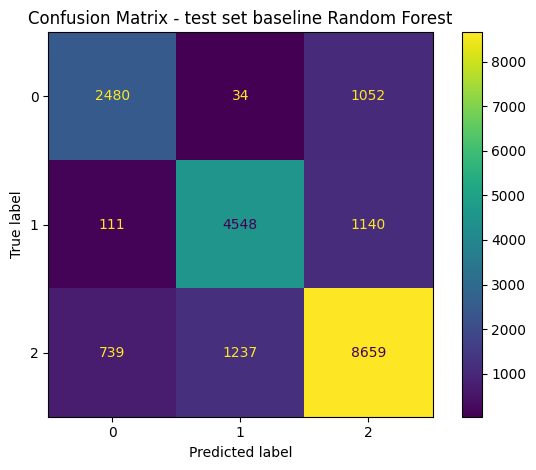

In [ ]:
#Confusio Matrix
cm = confusion_matrix(y_test, y_pred_base)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - test set baseline Random Forest")
plt.tight_layout()
plt.show()

In [26]:
# with mlflow.start_run(run_name="Random_Forest_baseline"):
#     mlflow.log_metrics(cv_metrics_base)
#     mlflow.log_metrics(test_metrics_base)


# Random Search CV

In [ ]:
#hyperparams for RandomSearchCV
param_distribution = {
    "forest_clf__n_estimators": [200, 300, 400, 500],
    "forest_clf__max_depth": [10, 15, 20, 25, None],
    "forest_clf__min_samples_leaf": [1, 2, 3, 5],
    "forest_clf__min_samples_split": [2, 5, 10, 15],
    "forest_clf__max_features": ["sqrt", "log2", 0.5],
    "forest_clf__bootstrap": [True],
}

#Random Search
random_search = RandomizedSearchCV(
    estimator=forest_clf,
    param_distributions=param_distribution,
    n_iter=30,
    scoring="f1_macro",
    n_jobs=4,
    cv=cv,
    random_state=42,
    verbose=1,
    return_train_score=False
)

#Fitting rs
random_search.fit(X_train, y_train)

#Save best esitmator and parameters
best_forest = random_search.best_estimator_
best_params = random_search.best_params_
best_cv_score = random_search.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline

In [28]:
best_params

{'forest_clf__n_estimators': 300,
 'forest_clf__min_samples_split': 2,
 'forest_clf__min_samples_leaf': 2,
 'forest_clf__max_features': 0.5,
 'forest_clf__max_depth': None,
 'forest_clf__bootstrap': True}

In [ ]:
#Cross validate on best model
cv_result_tuned = cross_validate(
    best_forest,
    X_train,
    y_train,
    scoring=scoring,
    cv=cv,
    n_jobs=6,
    return_train_score=False,
)
#Metrics for best model
cv_tuned_metrics_mean = {
    f"cv_{metrics}_mean_tuned": float(cv_result_tuned[f"test_{metrics}"].mean())
    for metrics in scoring.keys()
}

cv_tuned_metrics_std = {
    f"cv_{metrics}_std_tuned": float(cv_result_tuned[f"test_{metrics}"].std())
    for metrics in scoring.keys()
}

cv_metric_tuned = {**cv_tuned_metrics_mean, **cv_tuned_metrics_std}

pd.DataFrame([cv_metric_tuned])


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline

,cv_accuracy_mean_tuned,cv_balanced_accuracy_mean_tuned,cv_f1_macro_mean_tuned,cv_precision_macro_mean_tuned,cv_recall_macro_mean_tuned,cv_accuracy_std_tuned,cv_balanced_accuracy_std_tuned,cv_f1_macro_std_tuned,cv_precision_macro_std_tuned,cv_recall_macro_std_tuned
0,0.778988,0.776855,0.766841,0.758617,0.776855,0.003241,0.002674,0.003093,0.003489,0.002674


# Model Tuned

In [ ]:
#Final fit bes model
best_forest.fit(X_train, y_train)

y_pred_tuned = best_forest.predict(X_test)

test_metrics_tuned = {
    "test_accuracy": accuracy_score(y_test, y_pred_tuned),
    "test_balanced_accuracy": balanced_accuracy_score(y_test, y_pred_tuned),
    "test_f1_macro": f1_score(y_test, y_pred_tuned, average="macro"),
    "test_precision_macro": precision_score(y_test, y_pred_tuned, average="macro"),
    "test_recall_macro": recall_score(y_test, y_pred_tuned, average="macro"),
}

pd.DataFrame([test_metrics_tuned])

/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


,test_accuracy,test_balanced_accuracy,test_f1_macro,test_precision_macro,test_recall_macro
0,0.791,0.790719,0.780627,0.772356,0.790719


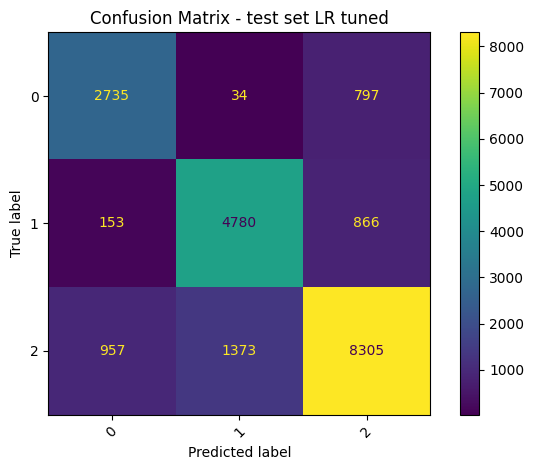

In [ ]:
#ConfusionMatrix
cm1 = confusion_matrix(y_test, y_pred_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix - test set LR tuned")
plt.tight_layout()
plt.show()

In [ ]:
#Mlflow
with mlflow.start_run(run_name="Random_Forest_tuned_v1"):
    mlflow.log_metrics(cv_metric_tuned)
    mlflow.log_metrics(test_metrics_tuned)
    mlflow.log_params(best_params)

🏃 View run Random_Forest_tuned_v1 at: http://127.0.0.1:5000/#/experiments/454137213308002966/runs/5f33855399de4207a9f8891ec7555dc7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/454137213308002966
